In [3]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [1]:
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
myfolder = "./"

# **Columns' names**

In [4]:
#Columns' names
'''
1)  unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  21
'''
unitNames = ['UnitNumber']
timeCycles = ["TimeInCycles"]
operSets = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
sensorMes = ["SensorMes"+str(j) for j in range(1, 22)] # de 1 à 21
columnsNames = unitNames + timeCycles + operSets +sensorMes

# **Datasets loading**

In [5]:
def data_loading(x):
  train_path = myfolder + "train_"+ x +".txt"
  test_path = myfolder + "test_"+ x +".txt"
  rul_path = myfolder + "RUL_"+ x +".txt"
  train = pd.read_csv(train_path, delim_whitespace=True, names=columnsNames)
  test = pd.read_csv(test_path, delim_whitespace=True, names=columnsNames)
  rul = pd.read_csv(rul_path, delim_whitespace=True, names=["RUL_FD"])
  return train, test, rul

train_fd001, test_fd001, rul_fd001 = data_loading("FD001")
train_fd002, test_fd002, rul_fd002 = data_loading("FD002")
train_fd003, test_fd003, rul_fd003 = data_loading("FD003")
train_fd004, test_fd004, rul_fd004 = data_loading("FD004")

In [6]:
# Forcer l'affichage de toutes les colonnes
pd.set_option('display.max_columns', None)

train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213


# **RUL column generation for train and test set**

In [7]:
def rul_train_generation(x):
  rul = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  rul.columns = ['UnitNumber', 'max']
  x = x.merge(rul, on=['UnitNumber'], how='left')
  x['RUL'] = x['max'] - x['TimeInCycles']
  x.drop('max', axis=1, inplace=True)
  return x

train_fd001 = rul_train_generation(train_fd001)
train_fd002 = rul_train_generation(train_fd002)
train_fd003 = rul_train_generation(train_fd003)
train_fd004 = rul_train_generation(train_fd004)

In [8]:
train_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213,318


In [9]:
def rul_test_generation(x, rul):

  rul["UnitNumber"] = rul.index + 1 # +1 pour que UnitNumber demarre de 1 au lieu de 0, car il s'agit du numero des moteur

  x = x.merge(rul, on=['UnitNumber'], how='left')

  max_cycle = pd.DataFrame(x.groupby('UnitNumber')['TimeInCycles'].max()).reset_index()
  max_cycle.columns = ['UnitNumber', 'max']
  x = x.merge(max_cycle, on=['UnitNumber'], how='left')
  x['RUL'] = x['RUL_FD'] + x['max'] - x['TimeInCycles']
  x.drop(['max', 'RUL_FD'], axis=1, inplace=True)

  return x

test_fd001 = rul_test_generation(test_fd001, rul_fd001)
test_fd002 = rul_test_generation(test_fd002, rul_fd002)
test_fd003 = rul_test_generation(test_fd003, rul_fd003)
test_fd004 = rul_test_generation(test_fd004, rul_fd004)

In [10]:
test_fd004.head(3)

,UnitNumber,TimeInCycles,OperSet1,OperSet2,OperSet3,SensorMes1,SensorMes2,SensorMes3,SensorMes4,SensorMes5,SensorMes6,SensorMes7,SensorMes8,SensorMes9,SensorMes10,SensorMes11,SensorMes12,SensorMes13,SensorMes14,SensorMes15,SensorMes16,SensorMes17,SensorMes18,SensorMes19,SensorMes20,SensorMes21,RUL
0,1,1,20.0072,0.700,100.0,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,8704.98,1.07,43.83,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.620,60.0,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,7999.94,0.93,36.11,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.842,100.0,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,8305.38,1.01,41.52,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249


# **RANDOM SAMPLE SELECTION**

In [11]:
'''element_counts = test_fd002[test_fd002['UnitNumber']==1]
len(element_counts)'''

"element_counts = test_fd002[test_fd002['UnitNumber']==1]\nlen(element_counts)"

In [12]:
import random

def selection_aleatoire(df, sample_size, rand_state):
    unique_values = df["UnitNumber"].unique()
    selected_rows = []
    for value in unique_values:
        rows = df[df["UnitNumber"] == value]
        if len(rows) < sample_size : # si la taille de l'echantillon donnée est superieur au nombre total de ligne pour un moteur, reinitialiser la valeur
            sample_size = len(rows)
        random_sample = rows.sample(n=sample_size, random_state = rand_state)  # Sélectionne 50 lignes aléatoires
        selected_rows.append(random_sample)
    result = pd.concat(selected_rows)
    return result

# **Data normalization**

In [13]:
def normalised_df(train, test):

  from sklearn.preprocessing import MinMaxScaler

  # Instancier l'objet MinMaxScaler pour normaliser les données
  scaler = MinMaxScaler()

  # Normaliser train
  train_scaled = scaler.fit_transform(train)
  train_df = pd.DataFrame(train_scaled)

  # Normaliser test
  test_scaled = scaler.fit_transform(test)
  test_df = pd.DataFrame(test_scaled)


  train_df.columns = train.columns
  test_df.columns = test.columns
    
  return train_df, test_df

# **Data splitting**

In [14]:
def data_split(train, test):

  # data split
  X_train = train.drop('RUL', axis=1)
  Y_train = train['RUL']
  X_test = test.drop('RUL', axis=1)
  Y_test = test['RUL']
    
  return X_train, Y_train, X_test, Y_test


# **Columns to drop**

In [15]:
def drop_columns(train, test, wich):
    if wich == 1:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [3, 6, 8, 9, 13, 14]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 2:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 10, 18, 19]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 3:
        operSets_to_drop = ["OperSet"+str(i) for i in [1, 2]] # 1 et 2
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [6, 7, 10, 12, 15, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
    elif wich == 4:
        operSets_to_drop = ["OperSet"+str(i) for i in range(1,4)] # 1,2 et 3
        sensorMes_to_drop = ["SensorMes"+str(j) for j in [1, 5, 6, 7, 12, 15, 18, 19, 20, 21]]
        cols_to_drop = operSets_to_drop + sensorMes_to_drop
        
    # drop columns 
    drop_cols=True
    if(drop_cols == True):
      train = train.drop(cols_to_drop, axis=1)
      test = test.drop(cols_to_drop, axis=1)
    return train, test

# **The LSTM model**

# 1 Layer

In [40]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

def my_lstm(train, test):

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    # Préparer les données pour le modèle LSTM
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle LSTM
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam())

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # Prédire les valeurs sur le jeu de test
    yhat = model.predict(test_X)

    # Afficher le MAE et le RMSE
    mae = mean_absolute_error(test_y, yhat)
    rmse = np.sqrt(mean_squared_error(test_y, yhat))

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Afficher les 200 premières valeurs prédites et réelles
    plt.figure(figsize=(10,6))
    plt.plot(yhat[:1000], label='Predicted')
    plt.plot(test_y[:1000], label='True')
    plt.title('Comparison of first 200 predicted and true values')
    plt.legend()
    plt.show()

    return model


410/410 [==============================] - 1s 821us/step
MAE: 0.08581957382167234
RMSE: 0.11399428375308328


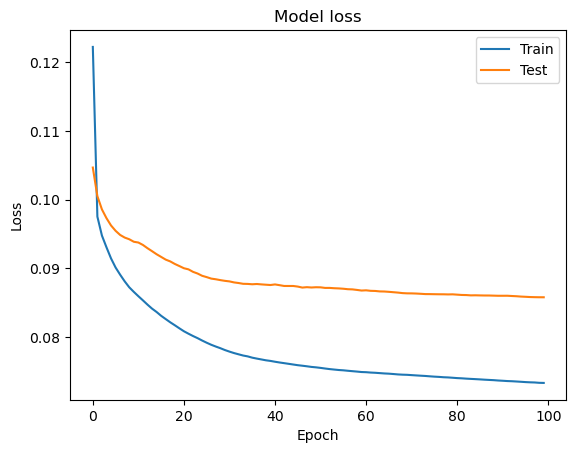

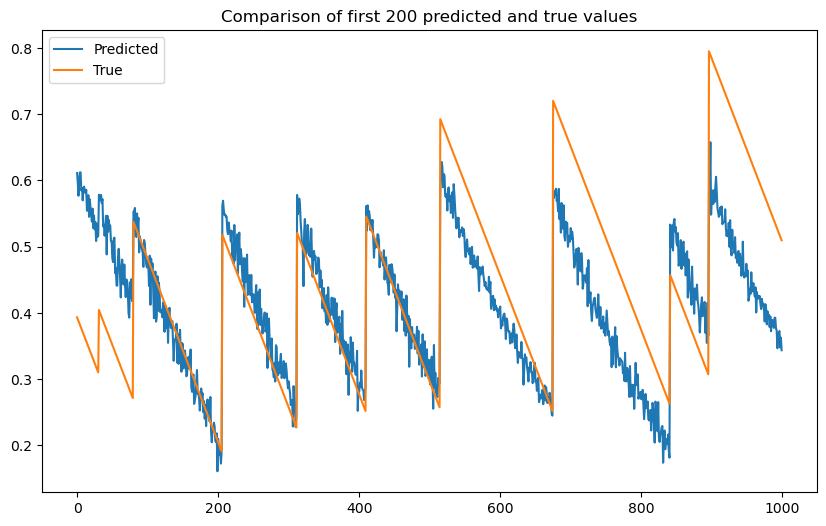

In [41]:
my_lstm(train_fd001, test_fd001)

1063/1063 [==============================] - 1s 809us/step
MAE: 0.10695963847118611
RMSE: 0.13986741016307466


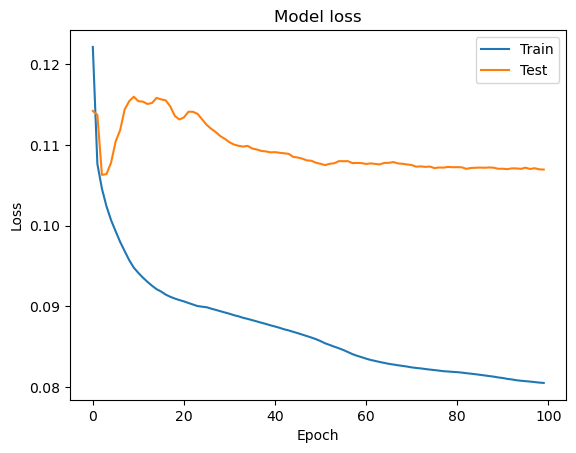

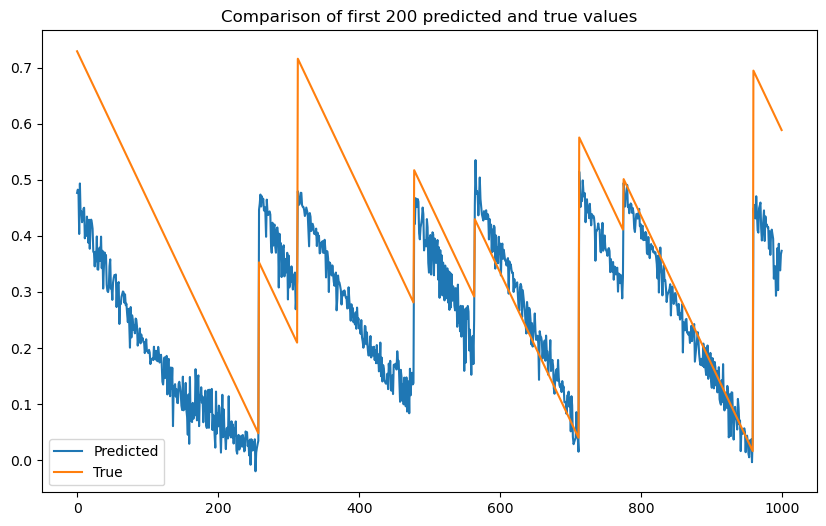

In [42]:
my_lstm(train_fd002, test_fd002)

519/519 [==============================] - 1s 695us/step
MAE: 0.09098000252205173
RMSE: 0.12811129064484528


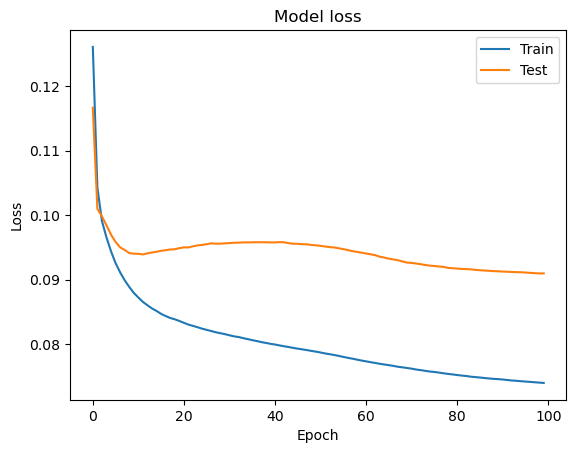

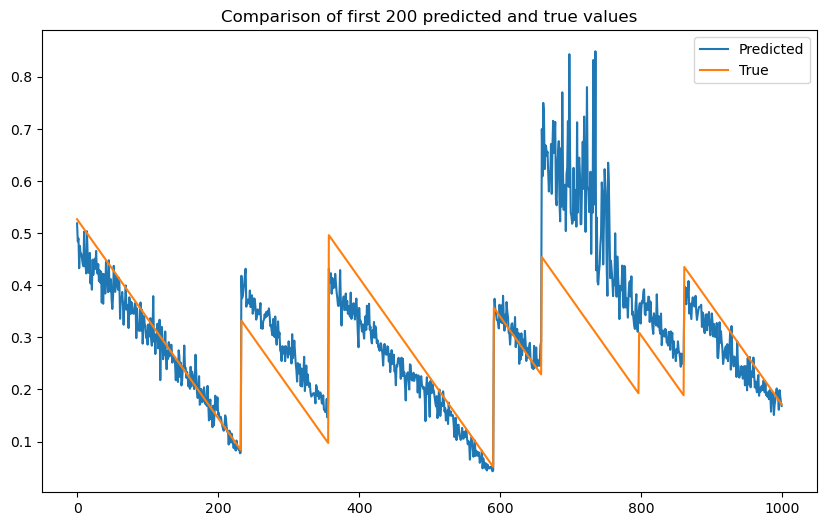

In [43]:
my_lstm(train_fd003, test_fd003)

1288/1288 [==============================] - 1s 728us/step
MAE: 0.10929670136226406
RMSE: 0.14206255965705905


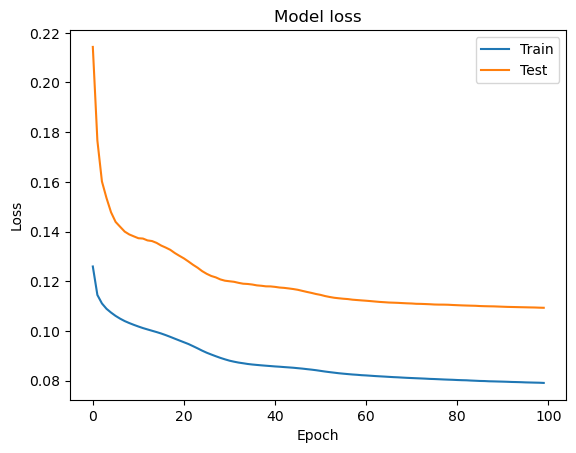

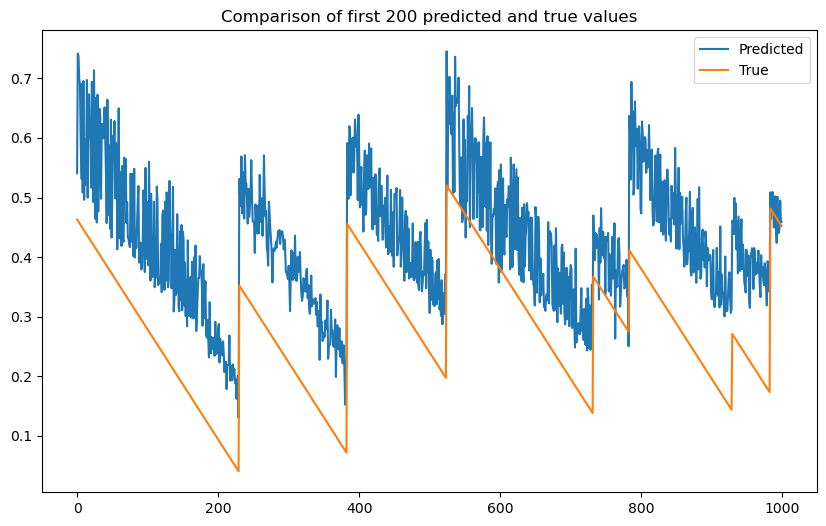

In [44]:
my_lstm(train_fd004, test_fd004)

# 2 Layers

In [69]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

def my_lstm2(train, test):

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    # Préparer les données pour le modèle LSTM
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle LSTM
    '''model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))'''
    model = Sequential()
    model.add(LSTM(
             units=100,
             return_sequences=True,
             input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=100,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='relu'))
    model.add(Activation("relu"))
    model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam())

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # Prédire les valeurs sur le jeu de test
    yhat = model.predict(test_X)

    # Afficher le MAE et le RMSE
    mae = mean_absolute_error(test_y, yhat)
    rmse = np.sqrt(mean_squared_error(test_y, yhat))

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Afficher les 200 premières valeurs prédites et réelles
    plt.figure(figsize=(10,6))
    plt.plot(yhat[:1000], label='Predicted')
    plt.plot(test_y[:1000], label='True')
    plt.title('Comparison of first 200 predicted and true values')
    plt.legend()
    plt.show()

    return model


410/410 [==============================] - 1s 1ms/step
MAE: 0.08551905350085352
RMSE: 0.11378438134895855


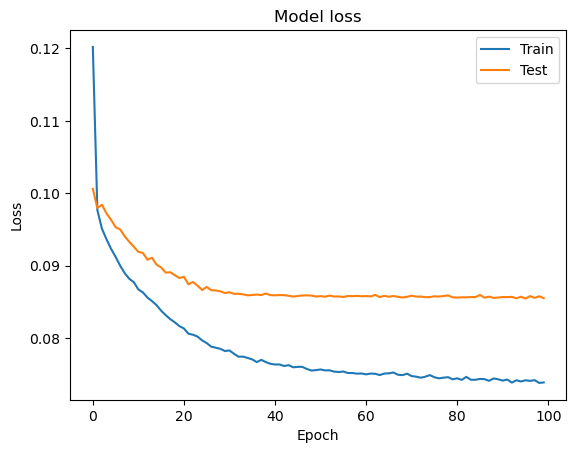

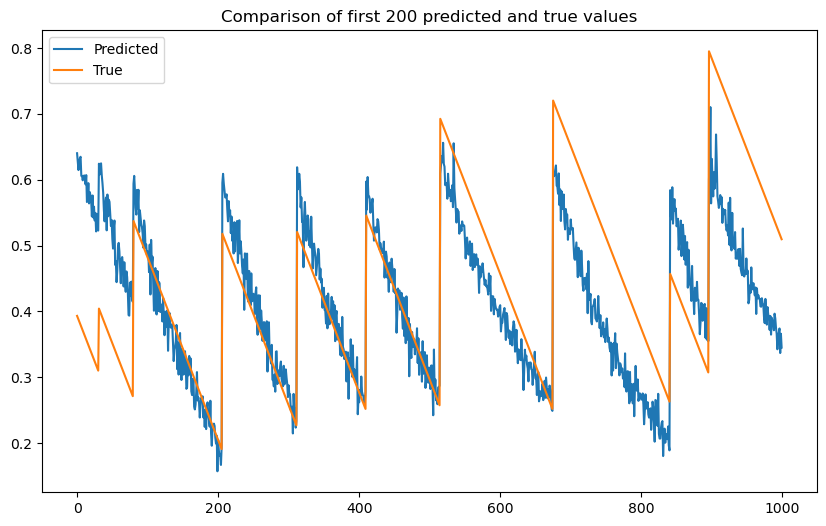

In [70]:
my_lstm2(train_fd001, test_fd001)

1063/1063 [==============================] - 2s 1ms/step
MAE: 0.09694841957312811
RMSE: 0.1266274685508965


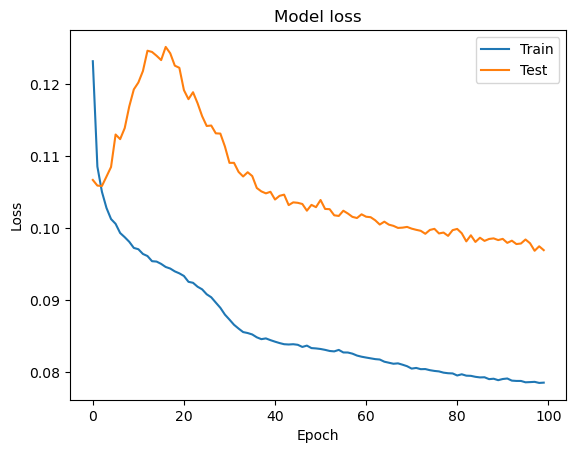

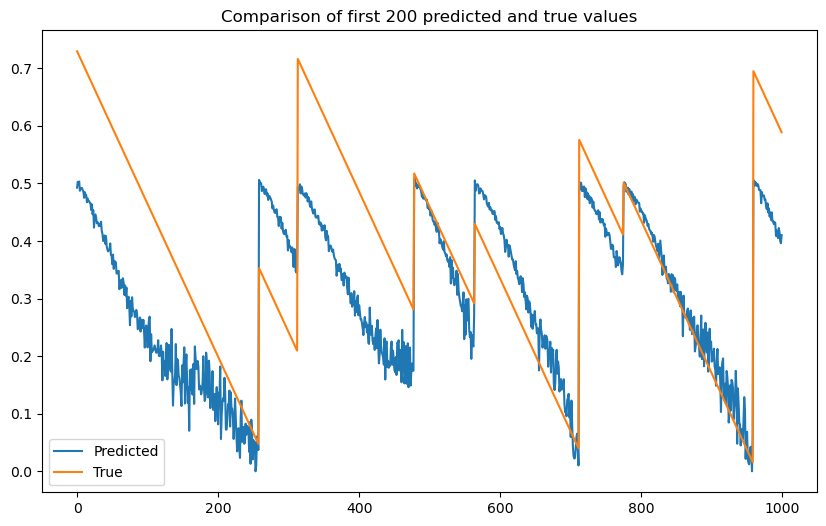

In [71]:
my_lstm2(train_fd002, test_fd002)

519/519 [==============================] - 2s 2ms/step
MAE: 0.09038286301259298
RMSE: 0.1266406025543873


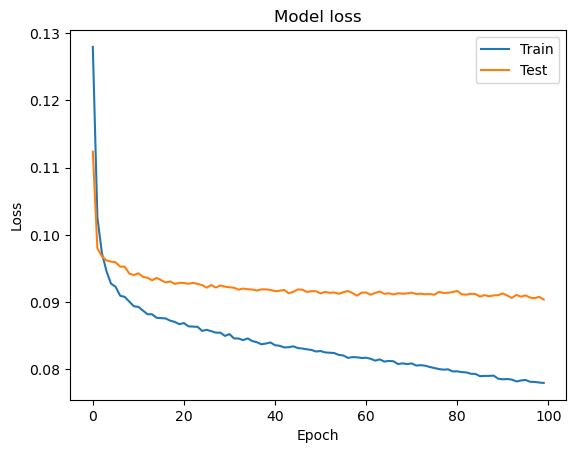

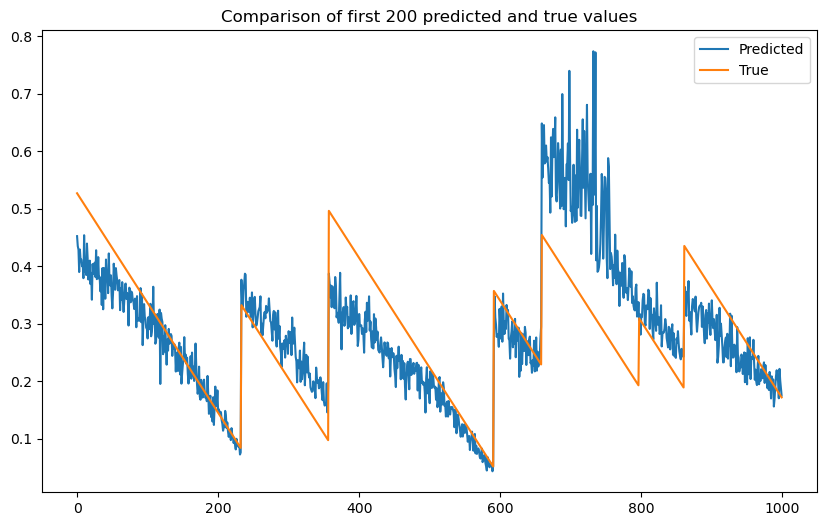

In [72]:
my_lstm2(train_fd003, test_fd003)

1288/1288 [==============================] - 2s 1ms/step
MAE: 0.10613153985855338
RMSE: 0.14139667607542322


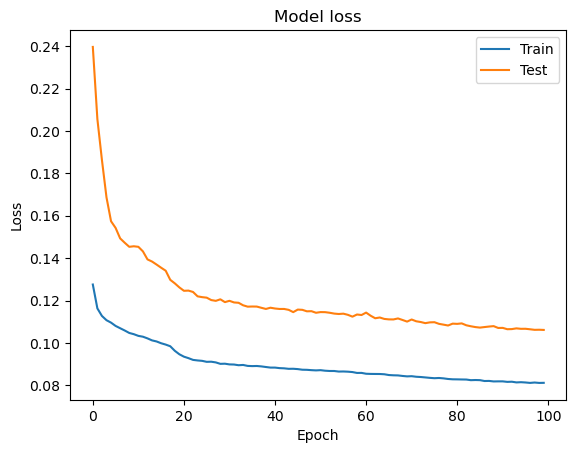

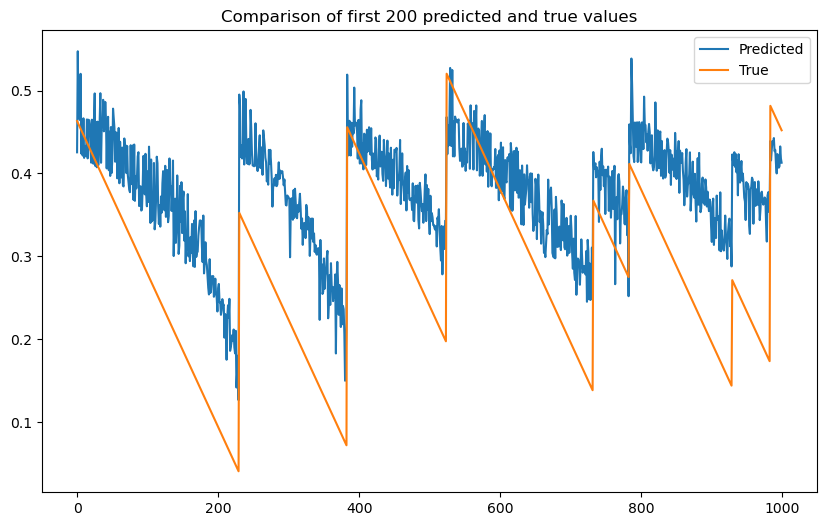

In [73]:
my_lstm2(train_fd004, test_fd004)

# Two Layers with Early Stopping

In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def my_lstm4(train_fd, test_fd):

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(train_fd)
    test = scaler.transform(test_fd)

    # Préparer les données pour le modèle LSTM
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle LSTM
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    plt.legend(loc='upper left')
    plt.show()

    # calculer le MAE et RMSE
    mae = mean_absolute_error(test_y, y_pred_test)
    mse = mean_squared_error(test_y, y_pred_test)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred_test))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)


Epoch 1/100
581/581 [==============================] - 7s 5ms/step - loss: 0.0857 - mse: 0.0144 - val_loss: 0.1250 - val_mse: 0.0223
Epoch 2/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0728 - mse: 0.0106 - val_loss: 0.1275 - val_mse: 0.0264
Epoch 3/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0697 - mse: 0.0100 - val_loss: 0.1196 - val_mse: 0.0224
Epoch 4/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0689 - mse: 0.0099 - val_loss: 0.1211 - val_mse: 0.0255
Epoch 5/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0676 - mse: 0.0097 - val_loss: 0.1202 - val_mse: 0.0245
Epoch 6/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0673 - mse: 0.0096 - val_loss: 0.1178 - val_mse: 0.0215
Epoch 7/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0669 - mse: 0.0096 - val_loss: 0.1153 - val_mse: 0.0198
Epoch 8/100
581/581 [==============================] - 2s 4ms/step - 

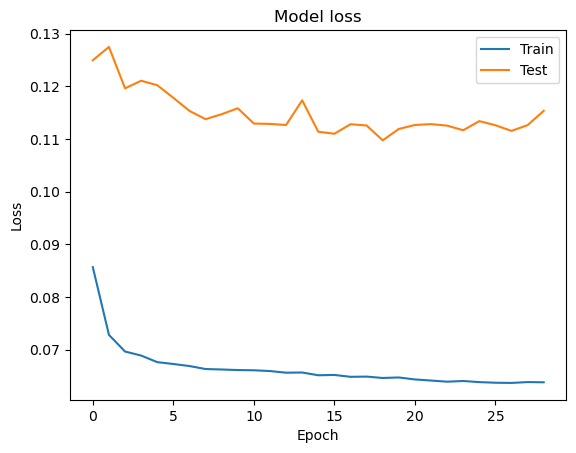

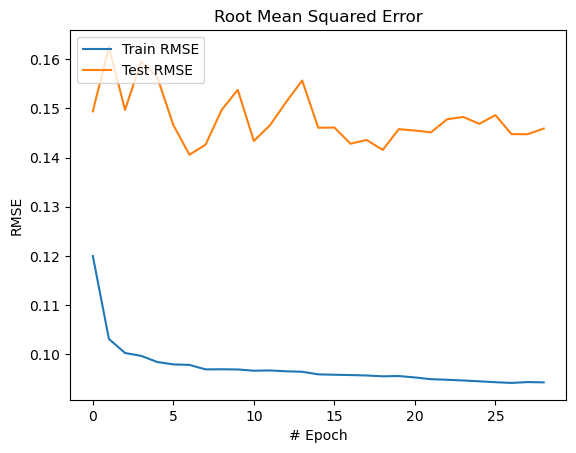

104/104 [==============================] - 0s 2ms/step - loss: 0.0692 - mse: 0.0099
Train RMSE: 0.09939050001746147
Test RMSE: 0.1120762034929147


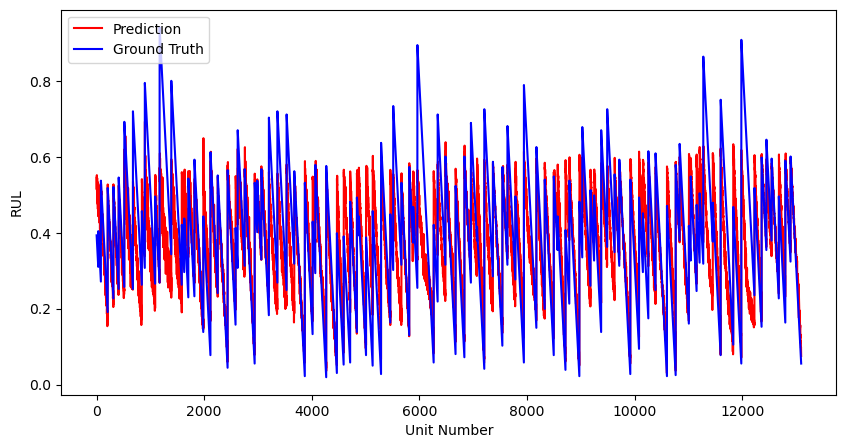

MAE:  0.0847872354056463
MSE:  0.01256107707152656
RMSE:  0.11207621099736803


In [82]:
my_lstm4(train_fd001, test_fd001)

Epoch 1/100
1512/1512 [==============================] - 11s 4ms/step - loss: 0.0962 - mse: 0.0167 - val_loss: 0.1173 - val_mse: 0.0218
Epoch 2/100
1512/1512 [==============================] - 5s 4ms/step - loss: 0.0877 - mse: 0.0141 - val_loss: 0.1157 - val_mse: 0.0218
Epoch 3/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0859 - mse: 0.0136 - val_loss: 0.1199 - val_mse: 0.0241
Epoch 4/100
1512/1512 [==============================] - 5s 3ms/step - loss: 0.0837 - mse: 0.0130 - val_loss: 0.1152 - val_mse: 0.0217
Epoch 5/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0808 - mse: 0.0123 - val_loss: 0.1142 - val_mse: 0.0216
Epoch 6/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0776 - mse: 0.0115 - val_loss: 0.0988 - val_mse: 0.0162
Epoch 7/100
1512/1512 [==============================] - 5s 3ms/step - loss: 0.0762 - mse: 0.0112 - val_loss: 0.1169 - val_mse: 0.0226
Epoch 8/100
1512/1512 [==============================]

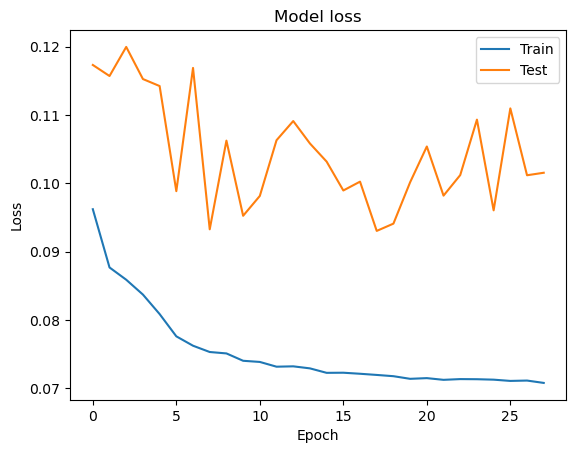

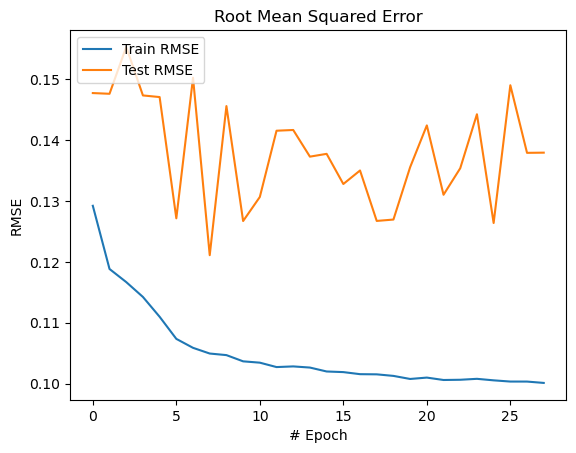

269/269 [==============================] - 2s 2ms/step - loss: 0.0722 - mse: 0.0104
Train RMSE: 0.1021497967047916
Test RMSE: 0.12533853554132846


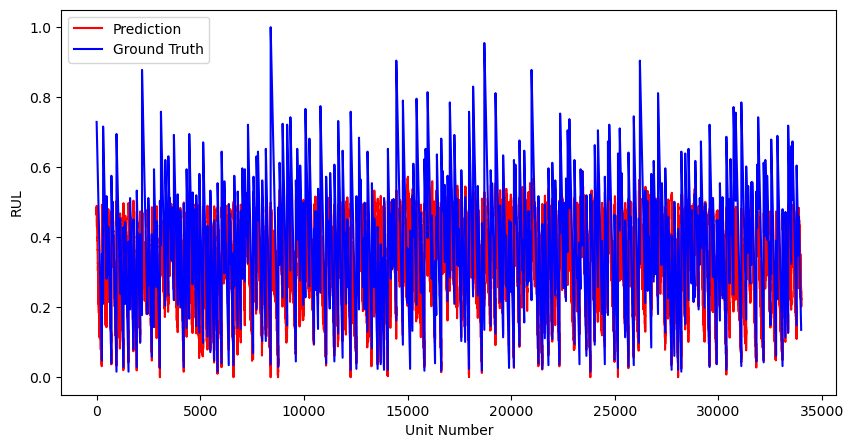

MAE:  0.09550965601905241
MSE:  0.015709756194528458
RMSE:  0.12533856626963807


In [83]:
my_lstm4(train_fd002, test_fd002)

Epoch 1/100
696/696 [==============================] - 9s 5ms/step - loss: 0.0900 - mse: 0.0169 - val_loss: 0.1179 - val_mse: 0.0333
Epoch 2/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0778 - mse: 0.0122 - val_loss: 0.1173 - val_mse: 0.0341
Epoch 3/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0757 - mse: 0.0115 - val_loss: 0.1165 - val_mse: 0.0339
Epoch 4/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0744 - mse: 0.0112 - val_loss: 0.1119 - val_mse: 0.0323
Epoch 5/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0734 - mse: 0.0110 - val_loss: 0.1109 - val_mse: 0.0329
Epoch 6/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0715 - mse: 0.0106 - val_loss: 0.1178 - val_mse: 0.0367
Epoch 7/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0702 - mse: 0.0105 - val_loss: 0.1014 - val_mse: 0.0271
Epoch 8/100
696/696 [==============================] - 3s 4ms/step - 

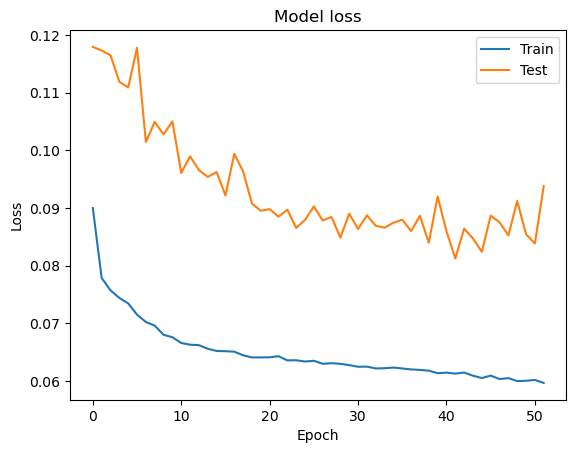

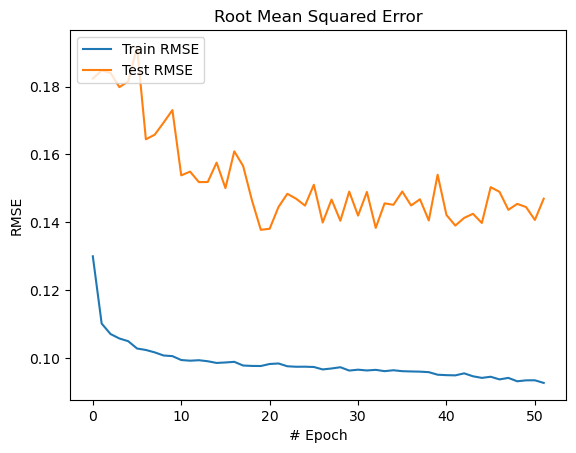

124/124 [==============================] - 0s 2ms/step - loss: 0.0623 - mse: 0.0098
Train RMSE: 0.09887376474020008
Test RMSE: 0.13482120998517327


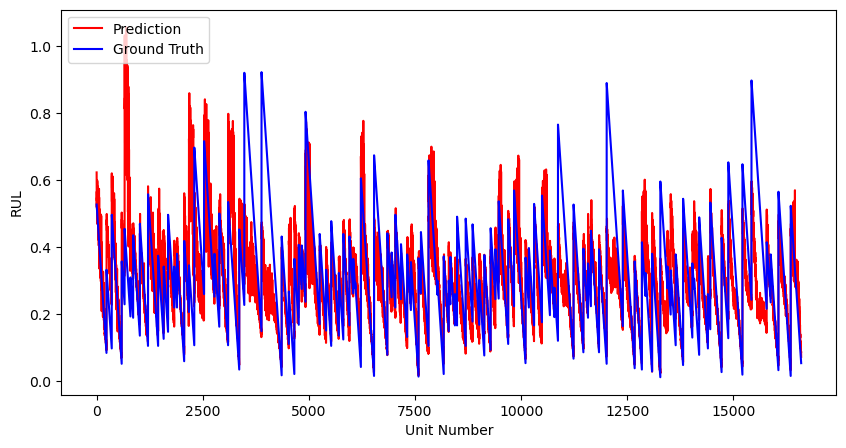

MAE:  0.08993543508696142
MSE:  0.018176753674908876
RMSE:  0.1348211914904659


In [84]:
my_lstm4(train_fd003, test_fd003)

Epoch 1/100
1723/1723 [==============================] - 11s 4ms/step - loss: 0.1018 - mse: 0.0180 - val_loss: 0.0796 - val_mse: 0.0105
Epoch 2/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0844 - mse: 0.0131 - val_loss: 0.0715 - val_mse: 0.0086
Epoch 3/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0782 - mse: 0.0117 - val_loss: 0.0735 - val_mse: 0.0085
Epoch 4/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0772 - mse: 0.0115 - val_loss: 0.0702 - val_mse: 0.0083
Epoch 5/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0767 - mse: 0.0114 - val_loss: 0.0703 - val_mse: 0.0079
Epoch 6/100
1723/1723 [==============================] - 6s 4ms/step - loss: 0.0762 - mse: 0.0112 - val_loss: 0.0695 - val_mse: 0.0078
Epoch 7/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0755 - mse: 0.0111 - val_loss: 0.0691 - val_mse: 0.0082
Epoch 8/100
1723/1723 [==============================]

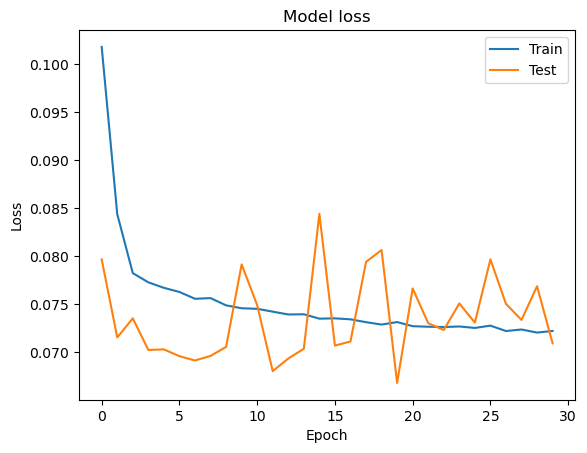

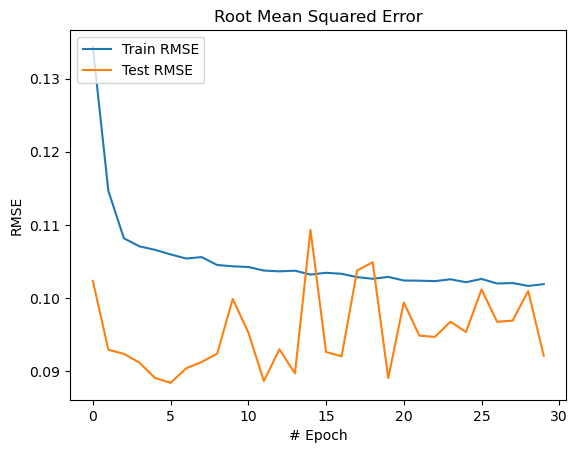

307/307 [==============================] - 1s 2ms/step - loss: 0.0689 - mse: 0.0097
Train RMSE: 0.0983721906237815
Test RMSE: 0.13871650917725173


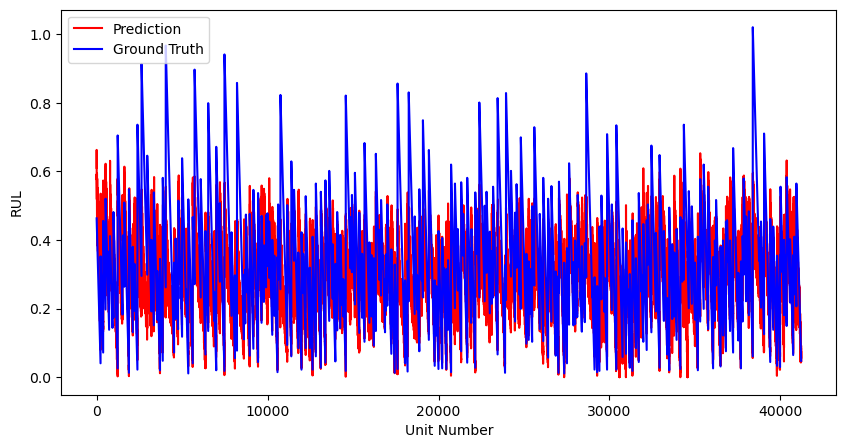

MAE:  0.10143119001605698
MSE:  0.019242261671027685
RMSE:  0.1387164794500916


In [85]:
my_lstm4(train_fd004, test_fd004)

# 2 Layers with Early Stopping and Feature Selection

In [98]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def my_lstm5(train_fd, test_fd, wich):
    
    new_train, new_test = drop_columns(train_fd, test_fd, wich)

    # Normaliser les données
    scaler = MinMaxScaler()

    train = scaler.fit_transform(new_train)
    test = scaler.transform(new_test)

    # Préparer les données pour le modèle LSTM
    train_X = train[:,:-1]
    train_y = train[:,-1]

    test_X = test[:,:-1]
    test_y = test[:,-1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Créer le modèle LSTM
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("relu"))

    # Compiler le modèle avec une optimisation
    model.compile(loss='mae', optimizer=Adam(), metrics=['mse'])

    # Entraîner le modèle
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

    # Afficher l'erreur d'entraînement et de validation sur une courbe
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # Calculer et afficher RMSE
    rmse_train = np.sqrt(history.history['mse'])
    rmse_test = np.sqrt(history.history['val_mse'])
    plt.plot(rmse_train, label='Train RMSE')
    plt.plot(rmse_test, label='Test RMSE')
    plt.title('Root Mean Squared Error')
    plt.ylabel('RMSE')
    plt.xlabel('# Epoch')
    plt.legend(loc='upper left')
    plt.show()

    scores = model.evaluate(train_X, train_y, verbose=1, batch_size=200)
    print('Train RMSE: {}'.format(np.sqrt(scores[1])))
    
    scores_test = model.evaluate(test_X, test_y, verbose=200)
    print('Test RMSE: {}'.format(np.sqrt(scores_test[1])))
    
    y_pred_test = model.predict(test_X, verbose=200)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred_test, color='red', label='Prediction')
    plt.plot(test_y, color='blue', label='Ground Truth')
    plt.ylabel("RUL")
    plt.xlabel("Unit Number")
    plt.legend(loc='upper left')
    plt.show()

    # calculer le MAE et RMSE
    mae = mean_absolute_error(test_y, y_pred_test)
    mse = mean_squared_error(test_y, y_pred_test)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred_test))
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)


Epoch 1/100
581/581 [==============================] - 7s 5ms/step - loss: 0.0863 - mse: 0.0146 - val_loss: 0.1311 - val_mse: 0.0246
Epoch 2/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0748 - mse: 0.0108 - val_loss: 0.1299 - val_mse: 0.0266
Epoch 3/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0725 - mse: 0.0103 - val_loss: 0.1251 - val_mse: 0.0258
Epoch 4/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0706 - mse: 0.0101 - val_loss: 0.1222 - val_mse: 0.0253
Epoch 5/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0698 - mse: 0.0099 - val_loss: 0.1183 - val_mse: 0.0243
Epoch 6/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0689 - mse: 0.0097 - val_loss: 0.1200 - val_mse: 0.0232
Epoch 7/100
581/581 [==============================] - 2s 4ms/step - loss: 0.0689 - mse: 0.0097 - val_loss: 0.1200 - val_mse: 0.0253
Epoch 8/100
581/581 [==============================] - 2s 4ms/step - 

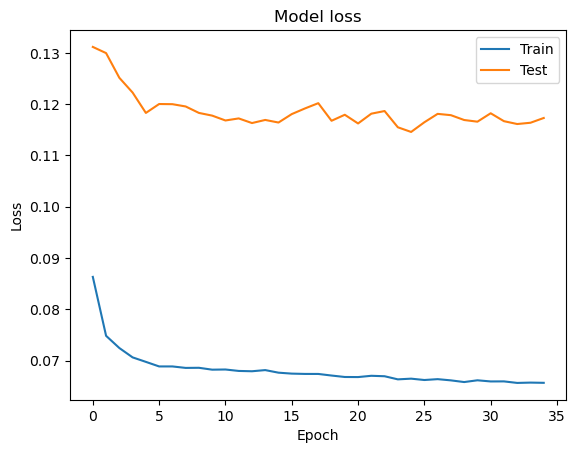

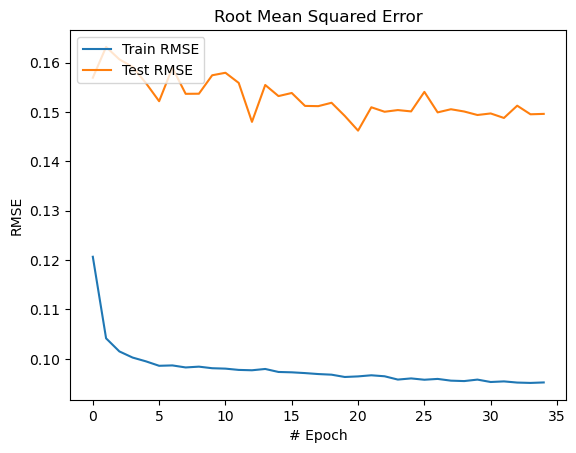

104/104 [==============================] - 0s 3ms/step - loss: 0.0693 - mse: 0.0101
Train RMSE: 0.10068928862486078
Test RMSE: 0.11807945075280853


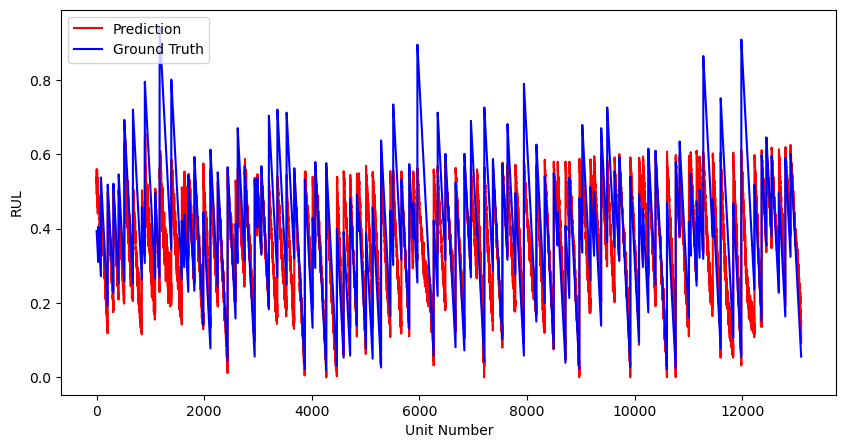

MAE:  0.08855310695796177
MSE:  0.013942762640783896
RMSE:  0.11807947595066594


In [99]:
my_lstm5(train_fd001, test_fd001, 1)

Epoch 1/100
1512/1512 [==============================] - 11s 5ms/step - loss: 0.0963 - mse: 0.0171 - val_loss: 0.1124 - val_mse: 0.0191
Epoch 2/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0874 - mse: 0.0140 - val_loss: 0.1154 - val_mse: 0.0218
Epoch 3/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0858 - mse: 0.0136 - val_loss: 0.1176 - val_mse: 0.0230
Epoch 4/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0846 - mse: 0.0133 - val_loss: 0.1194 - val_mse: 0.0235
Epoch 5/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0824 - mse: 0.0127 - val_loss: 0.1425 - val_mse: 0.0346
Epoch 6/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0802 - mse: 0.0122 - val_loss: 0.1175 - val_mse: 0.0234
Epoch 7/100
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0785 - mse: 0.0117 - val_loss: 0.1022 - val_mse: 0.0176
Epoch 8/100
1512/1512 [==============================]

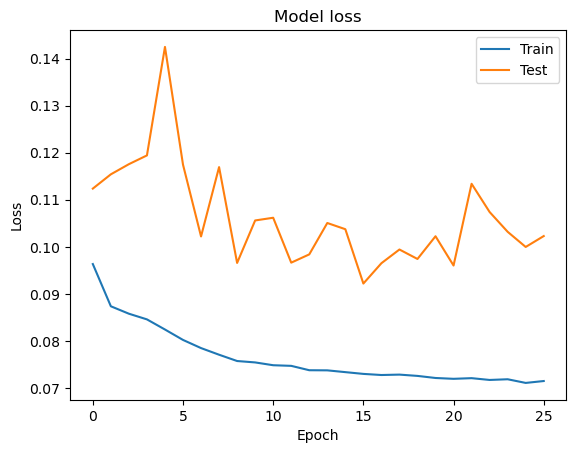

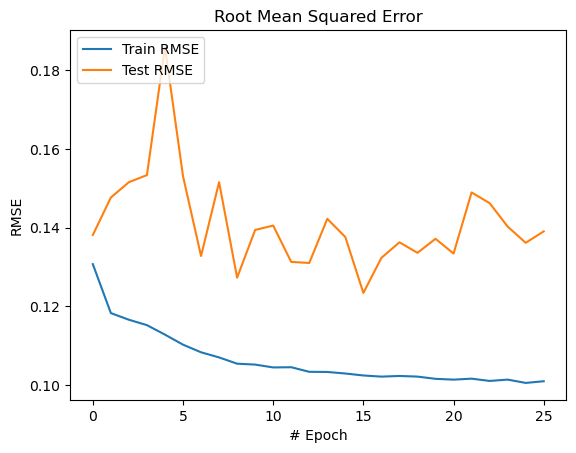

269/269 [==============================] - 1s 2ms/step - loss: 0.0743 - mse: 0.0106
Train RMSE: 0.10308267364163015
Test RMSE: 0.12484484595079118


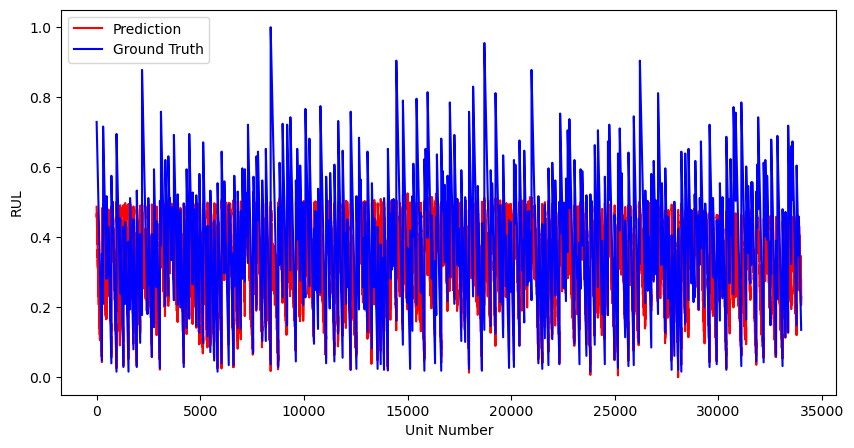

MAE:  0.09554605255022151
MSE:  0.015586231144562672
RMSE:  0.12484482826518153


In [102]:
my_lstm5(train_fd002, test_fd002, 2)

Epoch 1/100
696/696 [==============================] - 8s 5ms/step - loss: 0.0939 - mse: 0.0192 - val_loss: 0.1183 - val_mse: 0.0329
Epoch 2/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0787 - mse: 0.0127 - val_loss: 0.1128 - val_mse: 0.0318
Epoch 3/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0746 - mse: 0.0112 - val_loss: 0.1107 - val_mse: 0.0310
Epoch 4/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0730 - mse: 0.0109 - val_loss: 0.1105 - val_mse: 0.0322
Epoch 5/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0722 - mse: 0.0107 - val_loss: 0.1029 - val_mse: 0.0245
Epoch 6/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0714 - mse: 0.0106 - val_loss: 0.1029 - val_mse: 0.0287
Epoch 7/100
696/696 [==============================] - 3s 4ms/step - loss: 0.0704 - mse: 0.0104 - val_loss: 0.1038 - val_mse: 0.0277
Epoch 8/100
696/696 [==============================] - 3s 4ms/step - 

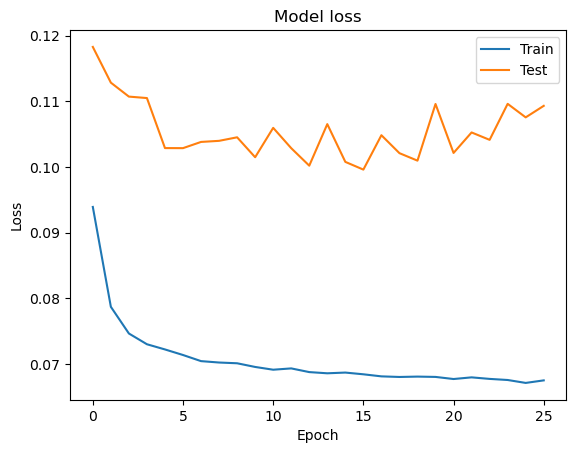

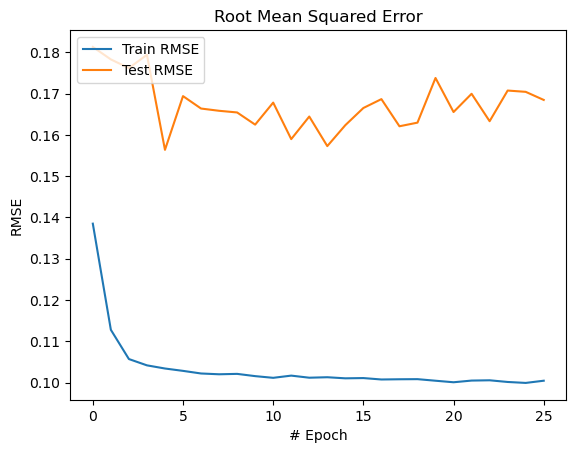

124/124 [==============================] - 0s 2ms/step - loss: 0.0698 - mse: 0.0114
Train RMSE: 0.10699965557122056
Test RMSE: 0.13204981797477328


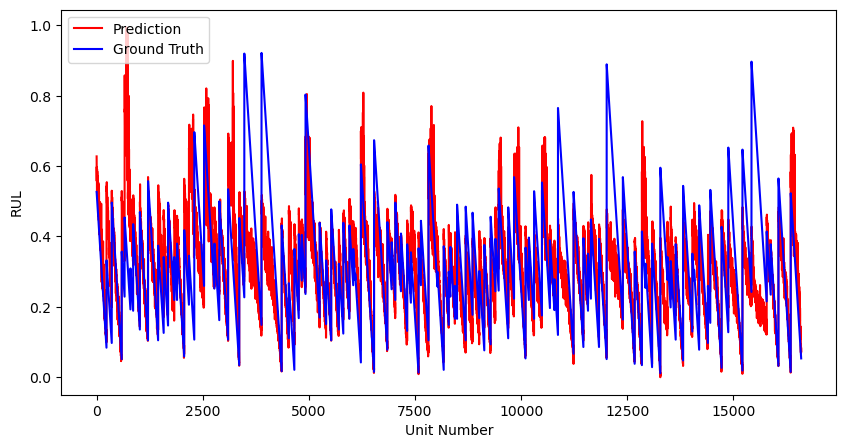

MAE:  0.08988359748950055
MSE:  0.017437160464983406
RMSE:  0.13204984083664548


In [103]:
my_lstm5(train_fd003, test_fd003, 3)

Epoch 1/100
1723/1723 [==============================] - 11s 4ms/step - loss: 0.1004 - mse: 0.0176 - val_loss: 0.0844 - val_mse: 0.0107
Epoch 2/100
1723/1723 [==============================] - 6s 3ms/step - loss: 0.0850 - mse: 0.0134 - val_loss: 0.0730 - val_mse: 0.0084
Epoch 3/100
1723/1723 [==============================] - 6s 4ms/step - loss: 0.0816 - mse: 0.0125 - val_loss: 0.0710 - val_mse: 0.0083
Epoch 4/100
1723/1723 [==============================] - 6s 4ms/step - loss: 0.0795 - mse: 0.0120 - val_loss: 0.0700 - val_mse: 0.0081
Epoch 5/100
1723/1723 [==============================] - 6s 3ms/step - loss: 0.0784 - mse: 0.0118 - val_loss: 0.0697 - val_mse: 0.0085
Epoch 6/100
1723/1723 [==============================] - 6s 4ms/step - loss: 0.0773 - mse: 0.0115 - val_loss: 0.0697 - val_mse: 0.0082
Epoch 7/100
1723/1723 [==============================] - 6s 3ms/step - loss: 0.0770 - mse: 0.0115 - val_loss: 0.0732 - val_mse: 0.0085
Epoch 8/100
1723/1723 [==============================]

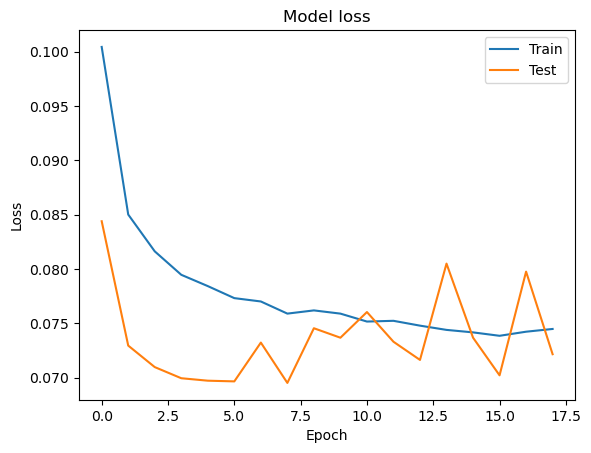

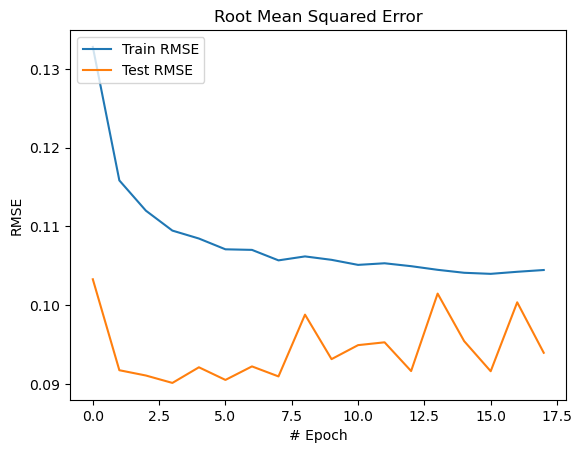

307/307 [==============================] - 1s 2ms/step - loss: 0.0710 - mse: 0.0098
Train RMSE: 0.09893612445108821
Test RMSE: 0.13911437235132706


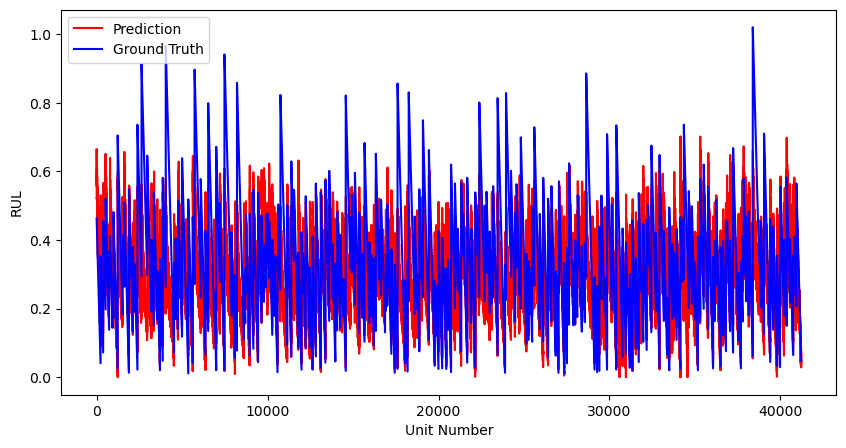

MAE:  0.10367293892585801
MSE:  0.01935280401606065
RMSE:  0.13911435589492785


In [104]:
my_lstm5(train_fd004, test_fd004, 4)